# ANHA4 to ANHA12 grid mapping

Using Scipy griddata for the interpolation, joblib Parallel to split jobs over multiple cores, and xarray to read and write to files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import time
from mpl_toolkits.basemap import Basemap, cm

# Library for running on multiple cores:
from joblib import Parallel

%matplotlib inline

Coordinate files to load, ANHA4:

In [2]:
nc_ANHA4_gridT = nc.Dataset('/data/brogalla/ANHA4/ANHA4-EXH005_y2002m01d05_gridT.nc')
nc_ANHA4_gridU = nc.Dataset('/data/brogalla/ANHA4/ANHA4-EXH005_y2002m01d05_gridU.nc')
nc_ANHA4_gridV = nc.Dataset('/data/brogalla/ANHA4/ANHA4-EXH005_y2002m01d05_gridV.nc')
nc_ANHA4_gridW = nc.Dataset('/data/brogalla/ANHA4/ANHA4-EXH005_y2002m01d05_gridW.nc')
nc_ANHA4_icemod = nc.Dataset('/data/brogalla/ANHA4/ANHA4-EXH005_y2002m01d05_icemod.nc')
lon_ANHA4_gridT = np.array(nc_ANHA4_gridT.variables['nav_lon']); lat_ANHA4_gridT = np.array(nc_ANHA4_gridT.variables['nav_lat']);
lon_ANHA4_gridU = np.array(nc_ANHA4_gridU.variables['nav_lon']); lat_ANHA4_gridU = np.array(nc_ANHA4_gridU.variables['nav_lat']);
lon_ANHA4_gridV = np.array(nc_ANHA4_gridV.variables['nav_lon']); lat_ANHA4_gridV = np.array(nc_ANHA4_gridV.variables['nav_lat']);
lon_ANHA4_gridW = np.array(nc_ANHA4_gridW.variables['nav_lon']); lat_ANHA4_gridW = np.array(nc_ANHA4_gridW.variables['nav_lat']);

Coordinate files to load, ANHA12:

In [3]:
nc_ANHA12_gridT = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
nc_ANHA12_gridU = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridU_y2002m01d05.nc')
nc_ANHA12_gridV = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridV_y2002m01d05.nc')
nc_ANHA12_gridW = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridW_y2002m01d05.nc')
nc_ANHA12_icemod = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_icemod_y2002m01d05.nc')
lon_ANHA12_gridT = np.array(nc_ANHA12_gridT.variables['nav_lon']); lat_ANHA12_gridT = np.array(nc_ANHA12_gridT.variables['nav_lat']);
lon_ANHA12_gridU = np.array(nc_ANHA12_gridU.variables['nav_lon']); lat_ANHA12_gridU = np.array(nc_ANHA12_gridU.variables['nav_lat']);
lon_ANHA12_gridV = np.array(nc_ANHA12_gridV.variables['nav_lon']); lat_ANHA12_gridV = np.array(nc_ANHA12_gridV.variables['nav_lat']);
lon_ANHA12_gridW = np.array(nc_ANHA12_gridW.variables['nav_lon']); lat_ANHA12_gridW = np.array(nc_ANHA12_gridW.variables['nav_lat']);

In [7]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate some field to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : input field lon/lat
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D model variable
    '''
    from scipy.interpolate import griddata
    
    LatLonPair = (nav_lon, nav_lat)
    var_out = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='linear')
#     Take nearest neighbour interpolation to fill nans
    print('NaN:', np.sum(np.isnan(var_out)))
    print('Not NaN:', np.sum(~np.isnan(var_out)))
    var_fill = griddata(LatLonPair, var_in, (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)] # first try replacing it with the nearest value
    print('NaN:', np.sum(np.isnan(var_out)))
    print('Not NaN:', np.sum(~np.isnan(var_out)))
    var_out[np.isnan(var_out)] = 0.0 # if that is still NaN, then set to zero.
    return var_out

In [8]:
def interp_gridT(filenameT, lon_ANHA4=lon_ANHA4_gridT, lat_ANHA4=lat_ANHA4_gridT, lon_ANHA12=lon_ANHA12_gridT, lat_ANHA12=lat_ANHA12_gridT):
    # Load file
    file    = xr.open_dataset('/data/brogalla/ANHA4/' + filenameT)
    varT    = file['votemper'].values
    varS    = file['vosaline'].values
    varx    = file['somxl010'].values
    
    # Interpolate ANHA4 variables onto ANHA12 grid:
    ANHA12_votemper = np.empty((1,50,2400,1632))
    ANHA12_vosaline = np.empty((1,50,2400,1632))
    for depth in range(0,50):
        ANHA12_votemper[0,depth,:,:] = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varT[0,depth,:,:].flatten(), lon_ANHA12, lat_ANHA12)
#         ANHA12_vosaline[0,depth,:,:] = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varS[0,depth,:,:].flatten(), lon_ANHA12, lat_ANHA12)
    
        
    print('NaN:', np.sum(np.isnan(ANHA12_votemper)))
    print('Not NaN:', np.sum(~np.isnan(ANHA12_votemper)))
#     ANHA12_somxl010 = np.empty((1,2400,1632))    
#     ANHA12_somxl010[0,:,:] = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varx[0,:,:].flatten(), lon_ANHA12, lat_ANHA12)
    
#     # Write interpolated values to file:
#     file_write = xr.Dataset(
#         {'votemper': (("time_counter","deptht","y","x"), ANHA12_votemper),
#          'vosaline': (("time_counter","deptht","y","x"), ANHA12_vosaline),
#          'somxl010': (("time_counter","y","x"), ANHA12_somxl010)
#         }, 
#         coords = {
#             "time_counter": np.zeros(1),
#             "deptht": np.zeros(50),
#             "y": np.zeros(2400),
#             "x": np.zeros(1632),
#         },
#     )
#     file_write.to_netcdf('/data/brogalla/ANHA4/remapped/ANHA4-EXH005_5d_gridT_'+filenameT[13:24]+'.nc')
    return

In [9]:
def interp_icemod(filenameI, lon_ANHA4=lon_ANHA4_gridT, lat_ANHA4=lat_ANHA4_gridT, lon_ANHA12=lon_ANHA12_gridT, lat_ANHA12=lat_ANHA12_gridT):
#     filenameI = filename[30:64]
#     print('Interpolating file: ', filenameI)
    
    # Load file
    file    = xr.open_dataset('/data/brogalla/ANHA4/' + filenameI)
    varp    = file['iiceprod'].values
    varf    = file['iicesflx'].values
    varl    = file['ileadfra'].values
    varw    = file['iwinstru'].values
    
    # Interpolate ANHA4 variables onto ANHA12 grid:
    ANHA12_iiceprod = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varp[0,:,:].flatten(), lon_ANHA12, lat_ANHA12)
    ANHA12_iicesflx = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varf[0,:,:].flatten(), lon_ANHA12, lat_ANHA12)
    ANHA12_ileadfra = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varl[0,:,:].flatten(), lon_ANHA12, lat_ANHA12)
    ANHA12_iwinstru = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varw[0,:,:].flatten(), lon_ANHA12, lat_ANHA12)

    # Write interpolated values to file:
#     file_write = xr.Dataset(
#         {'iiceprod': (("time_counter","y","x"), ANHA12_iiceprod),
#          'iicesflx': (("time_counter","y","x"), ANHA12_iicesflx),
#          'ileadfra': (("time_counter","y","x"), ANHA12_ileadfra),
#          'iwinstru': (("time_counter","y","x"), ANHA12_iwinstru)
#         }, 
#         coords = {
#             "time_counter": np.zeros(1),
#             "y": np.zeros(2400),
#             "x": np.zeros(1632),
#         },
#     )
    
#     file_write.to_netcdf('/data/brogalla/ANHA4/remapped/ANHA4-EXH005_5d_icemod_'+filenameI[13:24]+'.nc')
    
    return 

In [10]:
interp_icemod('ANHA4-EXH005_y2002m01d05_icemod.nc')

NaN: 3124286
Not NaN: 792514
NaN: 3075938
Not NaN: 840862
NaN: 2635659
Not NaN: 1281141
NaN: 2581348
Not NaN: 1335452
NaN: 3129861
Not NaN: 786939
NaN: 3081870
Not NaN: 834930
NaN: 2157801
Not NaN: 1758999
NaN: 2094443
Not NaN: 1822357


In [6]:
# Define joblib solver such that it passes a file to the main calculation and returns what you want
def joblib_solver(main_calc, file):
    calc = main_calc(file)
    return calc

In [7]:
gridT_files = ['ANHA4-EXH005_y2002m01d05_gridT.nc']#, 'ANHA4-EXH005_y2002m01d10_gridT.nc', 'ANHA4-EXH005_y2002m01d15_gridT.nc', \
#               'ANHA4-EXH005_y2002m01d20_gridT.nc', 'ANHA4-EXH005_y2002m01d25_gridT.nc', 'ANHA4-EXH005_y2002m01d30_gridT.nc']

In [8]:
# Add items to the list of jobs that need to be calculated. Each job reads in a file and performs a calculation on it.
joblist=[]
for file in gridT_files:
    positional_args=[interp_gridT, file]
    keyword_args={}
    joblist.append((joblib_solver,positional_args,keyword_args))

Check that the interpolation gives reasonable results:

In [16]:
start = time.time()

ncores=1
with Parallel(n_jobs=ncores,backend='threading') as parallel:
    parallel(joblist)
    
end = time.time() #print('{:.4f} s'.format(end-start))
print('GridT file calculation took: ', (end - start)/60, 'mins, with 1 core for 1 file using netcdf4 to read, and xarray to write to file.')

GridT file calculation took:  10.841614715258281 mins, with 1 core for 1 file using netcdf4 to read, and xarray to write to file.


In [16]:
start = time.time()

ncores=1
with Parallel(n_jobs=ncores,backend='threading') as parallel:
    parallel(joblist)
    
end = time.time()
print('GridT file calculation took: ', (end - start)/60, 'mins, with 1 core for 1 file using xarray and writing to file.')

GridT file calculation took:  10.53926839431127 mins, with 1 core for 1 file using xarray and writing to file.


In [9]:
start = time.time()
 
ncores=1
with Parallel(n_jobs=ncores,backend='threading') as parallel:
    parallel(joblist)
    
end = time.time()
print('GridT file calculation took: ', (end - start)/60, 'mins, with 1 core for 1 file using xarray and not writing to file.')

GridT file calculation took:  10.022475628058116 mins, with 1 core for 1 file using xarray and not writing to file.


In [9]:
def interp_gridU(filename, lon_ANHA4=lon_ANHA4_gridU, lat_ANHA4=lat_ANHA4_gridU, lon_ANHA12=lon_ANHA12_gridU, lat_ANHA12=lat_ANHA12_gridU):
    filenameU = filename[30:63]
    print('Interpolating file: ', filenameU)
    
    # Load file
    file    = xr.open_dataset('/scratch/brogalla/ANHA4_files/' + filenameU)
    varx    = file['vozocrtx'].values
    
    # Interpolate ANHA4 variables onto ANHA12 grid:
    ANHA12_vozocrtx = np.empty((1,50,2400,1632))
    for depth in range(0,50):
        ANHA12_vozocrtx[0,depth,:,:] = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varx[0,depth,:,:].flatten(), lon_ANHA12, lat_ANHA12)

    # Write interpolated values to file:
    file_write = xr.Dataset(
        {'vozocrtx': (("time_counter","deptht","y","x"), ANHA12_vozocrtx)}, 
        coords = {
            "time_counter": np.zeros(1),
            "deptht": np.zeros(50),
            "y": np.zeros(2400),
            "x": np.zeros(1632),
        },
    )
    
    file_write.to_netcdf('/data/brogalla/ANHA4/remapped/ANHA4-EXH005_5d_gridU_'+filenameU[13:24]+'.nc')
    return 

In [10]:
def interp_gridV(filename, lon_ANHA4=lon_ANHA4_gridV, lat_ANHA4=lat_ANHA4_gridV, lon_ANHA12=lon_ANHA12_gridV, lat_ANHA12=lat_ANHA12_gridV):
    filenameV = filename[30:63]
    print('Interpolating file: ', filenameV)
    
    # Load file
    file    = xr.open_dataset('/scratch/brogalla/ANHA4_files/' + filenameV)
    vary    = file['vomecrty'].values
    
    # Interpolate ANHA4 variables onto ANHA12 grid:
    ANHA12_vomecrty = np.empty((1,50,2400,1632))
    for depth in range(0,50):
        ANHA12_vomecrty[0,depth,:,:] = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), vary[0,depth,:,:].flatten(), lon_ANHA12, lat_ANHA12)

    # Write interpolated values to file:
    file_write = xr.Dataset(
        {'vomecrty': (("time_counter","deptht","y","x"), ANHA12_vomecrty)}, 
        coords = {
            "time_counter": np.zeros(1),
            "deptht": np.zeros(50),
            "y": np.zeros(2400),
            "x": np.zeros(1632),
        },
    )
    
    file_write.to_netcdf('/data/brogalla/ANHA4/remapped/ANHA4-EXH005_5d_gridV_'+filenameV[13:24]+'.nc')
    return

In [11]:
def interp_gridW(filename, lon_ANHA4=lon_ANHA4_gridW, lat_ANHA4=lat_ANHA4_gridW, lon_ANHA12=lon_ANHA12_gridW, lat_ANHA12=lat_ANHA12_gridW):
    filenameW = filename[30:63]
    print('Interpolating file: ', filenameW)
    
    # Load file
    file    = xr.open_dataset('/scratch/brogalla/ANHA4_files/' + filenameW)
    varv    = file['vovecrtz'].values
    vart    = file['votkeavt'].values

    # Interpolate ANHA4 variables onto ANHA12 grid:
    ANHA12_vovecrtz = np.empty((1,50,2400,1632))
    ANHA12_votkeavt = np.empty((1,50,2400,1632))
    for depth in range(0,50):
        ANHA12_vovecrtz[0,depth,:,:] = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), varv[0,depth,:,:].flatten(), lon_ANHA12, lat_ANHA12)
        ANHA12_votkeavt[0,depth,:,:] = interp_np(lon_ANHA4.flatten(), lat_ANHA4.flatten(), vart[0,depth,:,:].flatten(), lon_ANHA12, lat_ANHA12)

    # Write interpolated values to file:
    file_write = xr.Dataset(
        {'vovecrtz': (("time_counter","deptht","y","x"), ANHA12_vovecrtz),
         'votkeavt': (("time_counter","deptht","y","x"), ANHA12_votkeavt),
        }, 
        coords = {
            "time_counter": np.zeros(1),
            "deptht": np.zeros(50),
            "y": np.zeros(2400),
            "x": np.zeros(1632),
        },
    )
    file_write.to_netcdf('/data/brogalla/ANHA4/remapped/ANHA4-EXH005_5d_gridW_'+filenameW[13:24]+'.nc')
        
    return

Plot original and interpolated fields:

In [99]:
varT, varS, varx = zip(*results)

In [101]:
folder  = '/data/brogalla/ANHA4/'
file    = nc.Dataset(folder + gridT_files[0])
var_sal   = np.array(file.variables['vosaline'])
varsal_plot = np.ma.masked_where((var_sal > 1e2), var_sal)

In [19]:
land_color = '#a9a7a2'

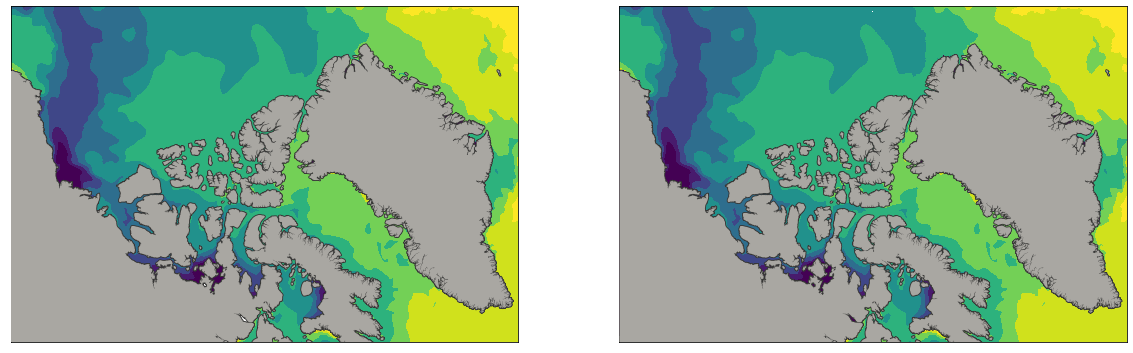

In [109]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

# ------ ANHA4 ---------
proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax[0])
x1, y1 = proj1(lon_ANHA4, lat_ANHA4)
proj1.drawcoastlines(color='#373736', linewidth=1.8)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
proj1.contourf(x1, y1, varsal_plot[0,0,:,:], levels=40, vmin=28, vmax=35, extend='both')

# ------ ANHA12 --------
proj2 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax[1])
x2, y2 = proj2(lon_ANHA12, lat_ANHA12)
proj2.drawcoastlines(color='#373736', linewidth=1.8)
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
proj2.contourf(x2, y2, varS[0][0,:,:], levels=40, vmin=28, vmax=35, extend='both')

## xarray attempts:

In [4]:
file_ANHA4  = '/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y2002m01d05_gridT.nc' 
file_ANHA12 = '/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc'

In [6]:
dset_ANHA4  = xr.open_dataset(file_ANHA4)
dset_ANHA12 = xr.open_dataset(file_ANHA12)

In [6]:
ANHA4_lat  = dset_ANHA4['nav_lat_grid_T']; ANHA4_lon  = dset_ANHA4['nav_lon_grid_T'];
ANHA12_lat = dset_ANHA12['nav_lat']; ANHA12_lon = dset_ANHA12['nav_lon'];

ANHA4_votemper = dset_ANHA4['votemper']
ANHA4_vosaline = dset_ANHA4['vosaline']
ANHA4_somxl010 = dset_ANHA4['somxl010']

In [7]:
print('------------------')
print('ANHA4 temperature variable shape: ', ANHA4_votemper.shape)
print('ANHA4 latitude variable shape: ', ANHA4_lat.shape)
print('ANHA4 longitude variable shape: ', ANHA4_lon.shape)
print('------------------')
print('ANHA12 latitude variable shape: ', ANHA12_lat.shape)
print('ANHA12 longitude variable shape: ', ANHA12_lon.shape)
print('Intended output shape ANHA12 temperature variable: (1, 50, 2400, 1632)')

------------------
ANHA4 temperature variable shape:  (1, 50, 800, 544)
ANHA4 latitude variable shape:  (800, 544)
ANHA4 longitude variable shape:  (800, 544)
------------------
ANHA12 latitude variable shape:  (2400, 1632)
ANHA12 longitude variable shape:  (2400, 1632)
Intended output shape ANHA12 temperature variable: (1, 50, 2400, 1632)


In [8]:
ANHA4_votemper_smaller = ANHA4_votemper[:,::5,::10,::10]
ANHA12_lat_smaller = ANHA12_lat[::20,::20].values
ANHA12_lon_smaller = ANHA12_lon[::20,::20].values

In [15]:
ANHA12_votemper_mapped = ANHA4_votemper.interp(x_grid_T=ANHA4_lon, y_grid_T=ANHA4_lat)